In [1]:
%autosave 2
%load_ext autoreload
%autoreload 2
%matplotlib inline

Autosaving every 2 seconds


# Analíse de reviews de videogames da Amazon

[dataset original](https://jmcauley.ucsd.edu/data/amazon/)

## Referencias
- [NLTK Book Online](http://www.nltk.org/book/)

* __Turing Talks__
    - [Introdução a NLTK com Dom Casmurro](https://medium.com/turing-talks/uma-an%C3%A1lise-de-dom-casmurro-com-nltk-343d72dd47a7)
    - [Introdução ao Processamento de Linguagem Natural com Baco Exu do Blues
](https://medium.com/turing-talks/introdu%C3%A7%C3%A3o-ao-processamento-de-linguagem-natural-com-baco-exu-do-blues-17cbb7404258)
    - [Introdução a Bag of Words e TF-IDF](https://medium.com/turing-talks/introdu%C3%A7%C3%A3o-a-bag-of-words-e-tf-idf-43a128151ce9)
        - [notebook](https://github.com/turing-usp/BoW-e-TFIDF/blob/master/BoW_e_TFIDF.ipynb)
    - [Sua primeira análise de sentimentos com scikit-learn](https://medium.com/turing-talks/sua-primeira-an%C3%A1lise-de-sentimentos-com-scikit-learn-a47c088ea7bd)
        - [modelos](https://www.kaggle.com/camillafonseca/nlp-an-lise-de-sentimento-do-olist-para-iniciantes#Modelos)
    - [Como Avaliar Seu Modelo de Classificação](https://medium.com/turing-talks/como-avaliar-seu-modelo-de-classifica%C3%A7%C3%A3o-acd2a03690e)
    

* __Libs__
    - [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)
    - [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
    - [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
    - [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
    - [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [2]:
from rich import print # print ficar bonitinho
from IPython.display import display

In [3]:
import pandas as pd
import numpy as np

In [88]:
from ast import literal_eval # para representar a str '[]' como lista []

In [4]:
import nltk
from nltk.corpus import stopwords # remover stopwords
from nltk import WordNetLemmatizer # lemantizador
from nltk.probability import FreqDist # grafico com frequencia de palavras no texto
import string, re # remover pontucao
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.model_selection import cross_val_score # Cross Validation

# Modelos:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression

In [5]:
#nltk.download()

In [87]:
from wordcloud import WordCloud
import cv2 as cv # Pra mascara do wordcloud

In [6]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import PercentFormatter
import matplotlib as mpl
import seaborn as sns

In [7]:
plt.style.use('ggplot')

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : '16'}

mpl.rc('font', **font)

In [10]:
dfReview = pd.read_csv('video_games_reviews_train.csv')

## Pré-processamento e Análise do corpus

### Visualizacao dos dataset e limpeza

In [11]:
dfReview.head(10)

,level_0,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,9604,222941,A1U1AK7HKB2BLN,B00CX6XKK6,jayfer,"[4, 51]",ive got to play this on both consoles now and ...,1,wasted 500 dollars on the xbox one.,1385078400,"11 22, 2013"
1,5428,106670,A1L1D50VH2AX7J,B0017UFWMS,Anjoyla,"[0, 0]",This game gives you a series of word puzzles t...,2,Margots Word Brain,1321833600,"11 21, 2011"
2,198,24455,A2JWU211CM0BYE,B00005RCR0,DCN2049,"[0, 1]",You should pretty much already know what this ...,4,"Excellent product, watch the discs",1360540800,"02 11, 2013"
3,6070,42574,A1DP3YZ2OQWAP4,B0000ARQMW,liz,"[0, 0]",I really like this game i love all the challen...,5,Jammin banging game,1383436800,"11 3, 2013"
4,11616,172598,A48Z207T98FN0,B004HYK8Y8,The Reverend,"[296, 368]",*** please read the 12/9/11 update below this ...,1,Consumers are NOT Beta-Testers !!! (updated),1322784000,"12 2, 2011"
5,9852,214525,A0815906MFVDTIFHGRQR,B00ATF5YY8,Diego B.,"[0, 0]","At the beginning I though, &#34;Wow! this game...",3,"Ok game, kinda bad story.",1374796800,"07 26, 2013"
6,11832,62284,A1OJXGNKA0QGUW,B000B6OBPS,J. Woods,"[1, 2]","Honestly I think this is pretty bad, and let m...",1,Don't believe the hype..,1333670400,"04 6, 2012"
7,838,80635,A2SP52NH44LRDS,B000MUW98O,Happy r/c,"[0, 3]",Try GRID racing game which I think is better.W...,2,Motorcycle doing wheelie can't flip backwards,1268956800,"03 19, 2010"
8,7485,167288,A1BBYSMT9YCODI,B0045EI7I4,korova,"[60, 67]",Long time fans of Grand Theft Auto know that e...,4,Rockstar's Rashomon,1288569600,"11 1, 2010"
9,2635,207739,A2TIP4NEY64PLK,B008DNUXA8,"Fun Times Mom ""Hayley""","[7, 9]",For the few minutes that my son played he had ...,1,RENT THIS ONE!!! IT COULDN'T KEEP A 6 YEAR OLD...,1355097600,"12 10, 2012"


In [12]:
dfReview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   level_0         8000 non-null   int64 
 1   index           8000 non-null   int64 
 2   reviewerID      8000 non-null   object
 3   asin            8000 non-null   object
 4   reviewerName    7916 non-null   object
 5   helpful         8000 non-null   object
 6   reviewText      7999 non-null   object
 7   overall         8000 non-null   int64 
 8   summary         8000 non-null   object
 9   unixReviewTime  8000 non-null   int64 
 10  reviewTime      8000 non-null   object
dtypes: int64(4), object(7)
memory usage: 687.6+ KB


* reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* asin - ID of the product, e.g. 0000013714
* reviewerName - name of the reviewer
* helpful - helpfulness rating of the review, e.g. 2/3
* reviewText - text of the review
* overall - rating of the product
* summary - summary of the review
* unixReviewTime - time of the review (unix time)
* reviewTime - time of the review (raw)

as colunas de interesse para o modelo sao: *reviewText* + *summary* como X e *overall* como y

In [17]:
# verificar se existem valores vazios nas colunas de interesse: reviewText, summary e overall: 

print('[bold red]NaN na coluna reviewText:[/bold red] ' + str(len(dfReview[dfReview['reviewText'].isna()])))
print('[bold red]NaN na coluna summary:[/bold red] ' + str(len(dfReview[dfReview['summary'].isna()])))
print('[bold red]NaN na coluna overall:[/bold red] ' + str(len(dfReview[dfReview['overall'].isna()])))

NaN na coluna reviewText: 1

NaN na coluna summary: 0

NaN na coluna overall: 0

Como só há valores NaN na coluna *reviewText*, ao unir com a a coluna *summary* formar um unico texto, nao vao mais haver NaN, portanto nao é nescessario excluir a respectiva linha

In [18]:
# unir as colunas reviewText e summary
dfReview['reviewText'] = dfReview.apply(lambda x: x.summary + ' ' + x.reviewText if str(x.reviewText) != 'nan' else x.summary, axis=1)

In [19]:
# removendo colunas desnecessarias:
dfReview.drop(['level_0', 'index', 'unixReviewTime', 
               'reviewerID', "reviewerName", "summary"], axis=1, inplace=True)

In [78]:
# convertendo reviewTime em datetime:
dfReview['reviewTime'] = pd.to_datetime(dfReview['reviewTime'], format='%m %d, %Y')

Como especificado no enunciad, deve-se fazer uma classificacao binaria, 0 para avaliacao menor ou igual a 3 e 1 para maiores, estao crio uma nova coluna binaria em funcao da *overall* mas nao deleto a original para algumas analises

In [20]:
# criar coluna binaria do overall 1 if nota > 3 else 0
dfReview['overallBinary'] = dfReview['overall'].apply(lambda x: 1 if x > 3 else 0)

In [23]:
print('[bold blue]Dataset limpo:[/bold blue]')
dfReview.head()

Dataset limpo:

,asin,helpful,reviewText,overall,reviewTime,overallBinary
0,B00CX6XKK6,"[4, 51]",wasted 500 dollars on the xbox one. ive got to...,1,"11 22, 2013",0
1,B0017UFWMS,"[0, 0]",Margots Word Brain This game gives you a serie...,2,"11 21, 2011",0
2,B00005RCR0,"[0, 1]","Excellent product, watch the discs You should ...",4,"02 11, 2013",1
3,B0000ARQMW,"[0, 0]",Jammin banging game I really like this game i ...,5,"11 3, 2013",1
4,B004HYK8Y8,"[296, 368]",Consumers are NOT Beta-Testers !!! (updated) *...,1,"12 2, 2011",0


### Remocao de stopwords e pontuacao

In [24]:
def tratamento_basico(texto,
                      pontuacao = re.compile('|'.join(map(re.escape, string.punctuation))),
                      stpwrds = stopwords.words('english')):
    """tratamento basico do texto com remocao de pontucao e e stopwords
    
    input:
         - texto: (str) -> menssagem a ser processada
         - pontuacao (re.Pattern) -> caracteres de pontuacao a serem removidos
                                     compilados em uma regex
                                     default: providos pelo string.punctuation
                                              usando o re.compile('|'.join(map(re.escape, string.punctuation)))
         - stpwrds (list)  -> lista de stopwords
                              default: providos pela funcao stopwords.words('english') da lib nltk.corpus
    output:
         (str) ->  menssagem pre-processada em caixa baixa
    """
    
    # Caixa baixa
    texto = texto.lower()
    
    # para pontucao so usar o metodo sub da regex de entrada
    texto = pontuacao.sub("", texto)
    
    # para as stopwords fazer por compreensao de lista, juntando chars em
    # palavras para nao remover as sopwords que estejam dentro de uma outra palavra
    # e usar os texto em caixa baixa para dar match
    texto = [palavra for palavra in texto.split() if palavra not in stpwrds]
    
    # Retorna vetor pra um texto
    texto = " ".join(texto)
    
    return texto

In [25]:
print('[bold red]antes do tratamento_basico():[/bold red]')
print()
dfReview['reviewText'].head(10)

antes do tratamento_basico():

0    wasted 500 dollars on the xbox one. ive got to...
1    Margots Word Brain This game gives you a serie...
2    Excellent product, watch the discs You should ...
3    Jammin banging game I really like this game i ...
4    Consumers are NOT Beta-Testers !!! (updated) *...
5    Ok game, kinda bad story. At the beginning I t...
6    Don't believe the hype.. Honestly I think this...
7    Motorcycle doing wheelie can't flip backwards ...
8    Rockstar's Rashomon Long time fans of Grand Th...
9    RENT THIS ONE!!! IT COULDN'T KEEP A 6 YEAR OLD...
Name: reviewText, dtype: object

In [26]:
print('[bold red]depois do tratamento_basico():[/bold red]')
print()

# remover os numeros tambem
# incluir a apalvra game nos stopwords
StopWords = stopwords.words('english')
StopWords.append('game')
StopWords.append('games')
dfReview['reviewText_prep'] = dfReview['reviewText'].apply(lambda x:(tratamento_basico(x, 
                                                                                       pontuacao=re.compile('|'.join(map(re.escape, string.punctuation+'1234567890'))),
                                                                                       stpwrds=StopWords)))
dfReview['reviewText_prep'].head(10)

depois do tratamento_basico():

0    wasted dollars xbox one ive got play consoles ...
1    margots word brain gives series word puzzles f...
2    excellent product watch discs pretty much alre...
3    jammin banging really like love challenges lov...
4    consumers betatesters updated please read upda...
5    ok kinda bad story beginning though wow looks ...
6    dont believe hype honestly think pretty bad le...
7    motorcycle wheelie cant flip backwards try gri...
8    rockstars rashomon long time fans grand theft ...
9    rent one couldnt keep year olds attention minu...
Name: reviewText_prep, dtype: object

In [32]:
#plt.figure(figsize=(20,9))
#gs = gridspec.GridSpec(2, 1)

#ax0 = plt.subplot(gs[0:1])
#ax1 = plt.subplot(gs[1:])

#p = dfReview['len_review_words'].plot(kind='box', ax=ax0, vert=False, )

### Lemmatização

In [29]:
lemmantizador = nltk.WordNetLemmatizer()

def lemmanizacao(texto):
    """retorna texto lemmantizado
    
    entrada:
        - texto(str): string a ser lemmantizada
    saida:
        - (str): texto de entrada lemmantizado
    """
    
    tokentxt =  [lemmantizador.lemmatize(palavra) for palavra in texto.split()]
    
    return ' '.join(tokentxt)

In [30]:
dfReview['reviewText_prep'] =  dfReview['reviewText_prep'].apply(lambda x:lemmanizacao(x))
dfReview['reviewText_prep']

0       wasted dollar xbox one ive got play console ho...
1       margots word brain give series word puzzle fig...
2       excellent product watch disc pretty much alrea...
3       jammin banging really like love challenge love...
4       consumer betatesters updated please read updat...
                              ...                        
7995    scrolling arrived mail promptly working great ...
7996    style substance perfect example style substanc...
7997    exceeds expectation let tell start im big yugi...
7998    good deal new delivers bought solely web swing...
7999    star ocean last hope international short revie...
Name: reviewText_prep, Length: 8000, dtype: object

### Analises

In [31]:
# adiciona coluna com quantidade de palavras e quantidade de caracteres
dfReview['len_review_words'] = dfReview['reviewText_prep'].apply(lambda x:len(x.split()))
dfReview['len_review_chars'] = dfReview['reviewText_prep'].apply(lambda x:len(x))

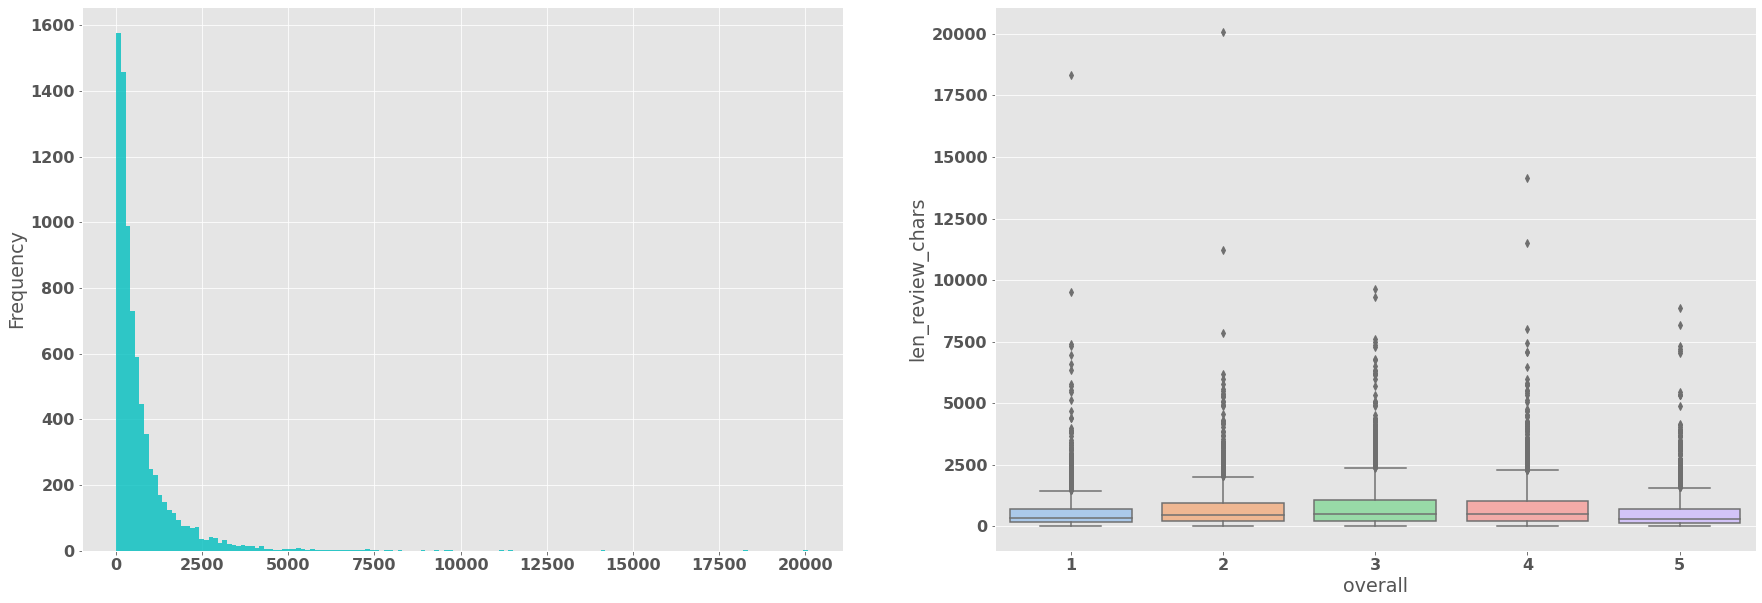

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
p = dfReview['len_review_chars'].plot(kind='hist', bins=150, ax=ax[0], alpha=.8, color='c', label='words')
p = sns.boxplot(data=dfReview, x='overall', y='len_review_chars', palette='pastel', ax=ax[1])

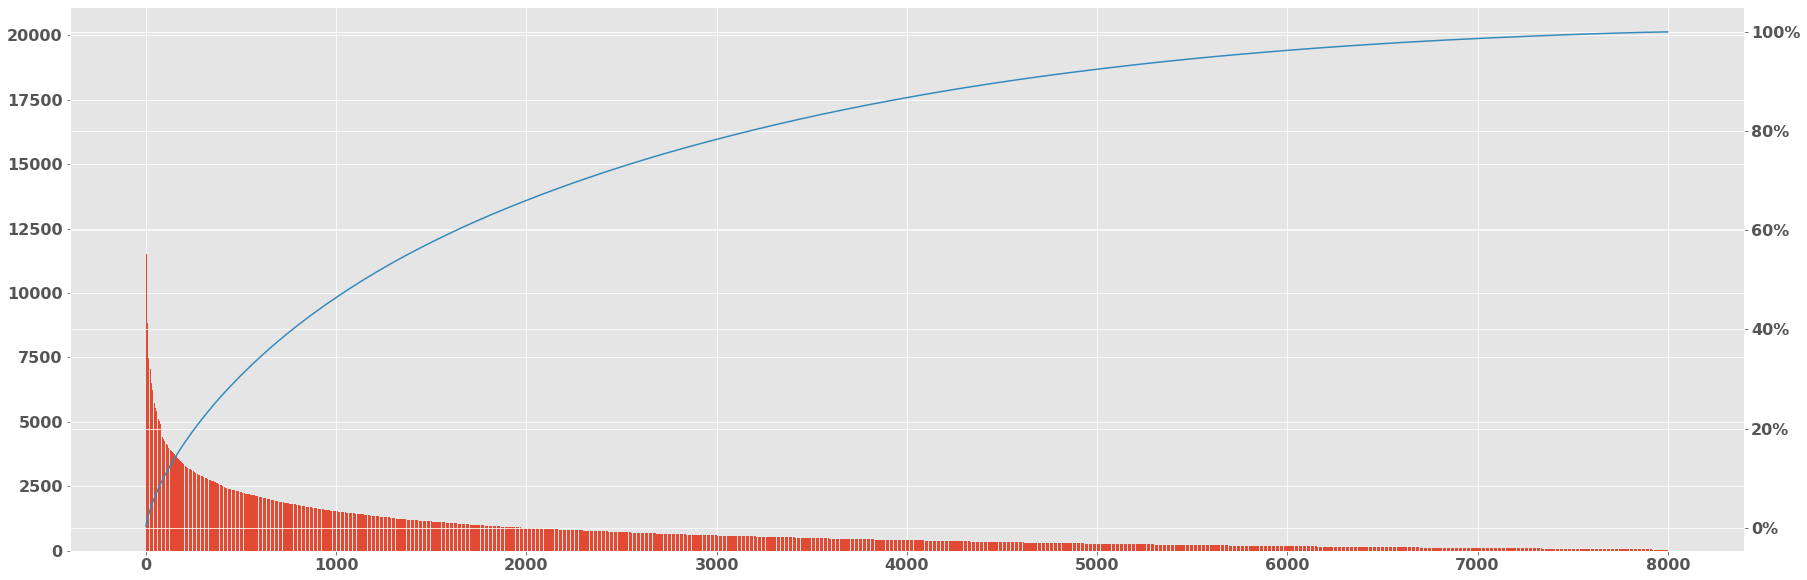

In [64]:
df = dfReview.sort_values(by='len_review_chars', ascending=False).reset_index()
df["cumpercentage"] = df["len_review_chars"].cumsum()/df["len_review_chars"].sum()*100

fig, ax = plt.subplots(figsize=(30, 10))
ax.bar(df.index, df["len_review_chars"], color="C0")
ax2 = ax.twinx()
ax2.plot(df.index, df["cumpercentage"], color="C1")
ax2.yaxis.set_major_formatter(PercentFormatter())

[]

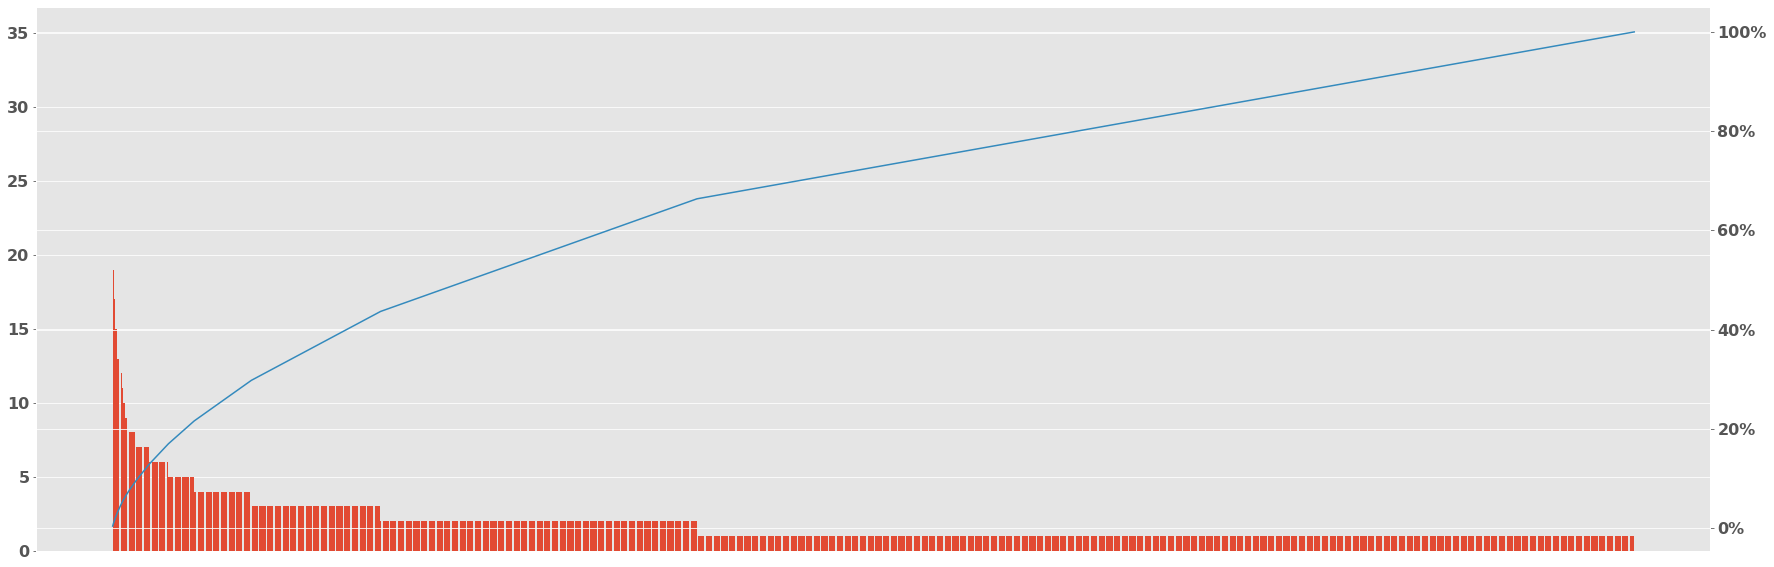

In [68]:
df = dfReview.groupby('asin').count().sort_values(by='helpful',ascending=False)[['reviewText']]
df["cumpercentage"] = df["reviewText"].cumsum()/df["reviewText"].sum()*100

fig, ax = plt.subplots(figsize=(30, 10))
ax.bar(df.index, df["reviewText"], color="C0")
ax2 = ax.twinx()
ax2.plot(df.index, df["cumpercentage"], color="C1")
ax2.yaxis.set_major_formatter(PercentFormatter())

ax2.axes.get_xaxis().set_ticks([])
ax.axes.get_xaxis().set_ticks([])

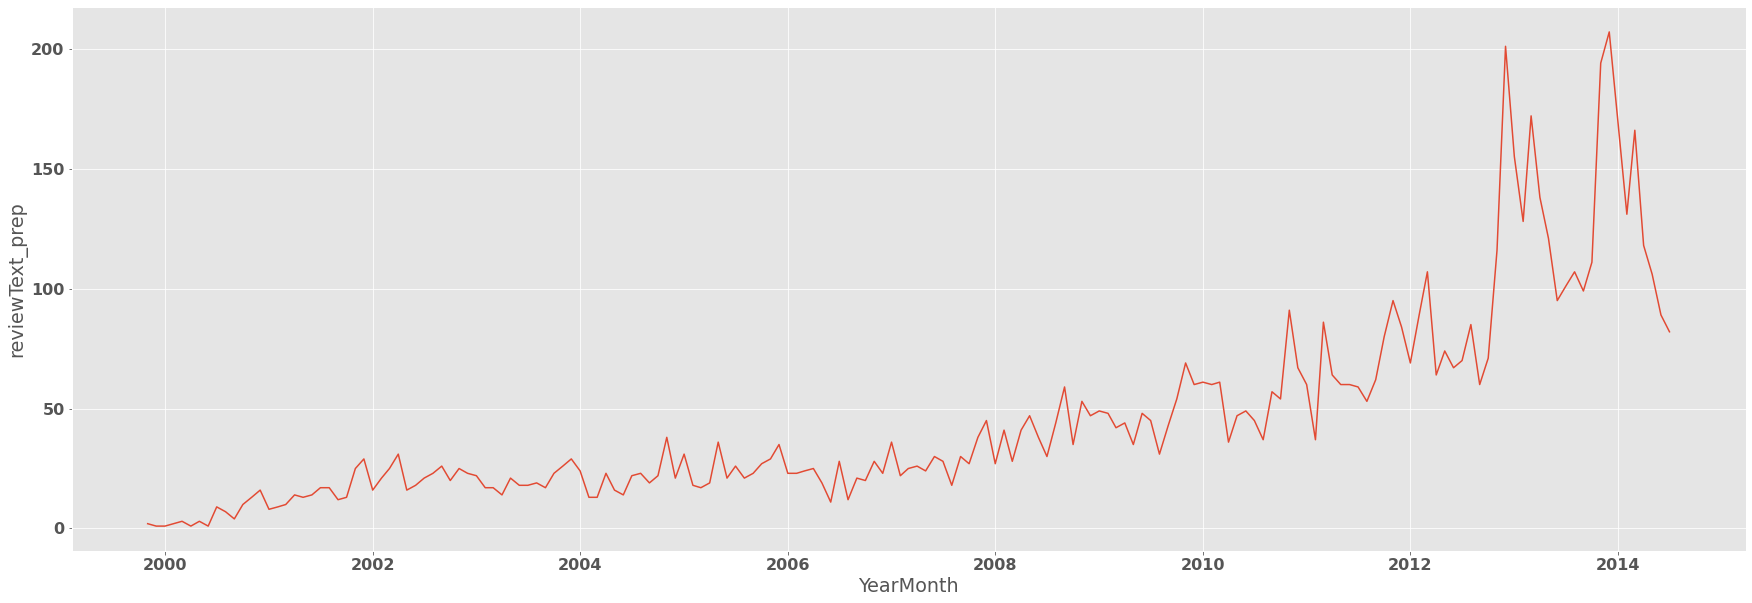

In [81]:
plt.figure(figsize=(30, 10))
dfReview['YearMonth'] = dfReview['reviewTime'].apply(lambda x:pd.to_datetime(str(x.year) + ' ' + str(x.month), format='%Y %m'))
p = sns.lineplot(data=dfReview.groupby('YearMonth').count().reset_index(),
                 x='YearMonth',
                 y='reviewText_prep',)

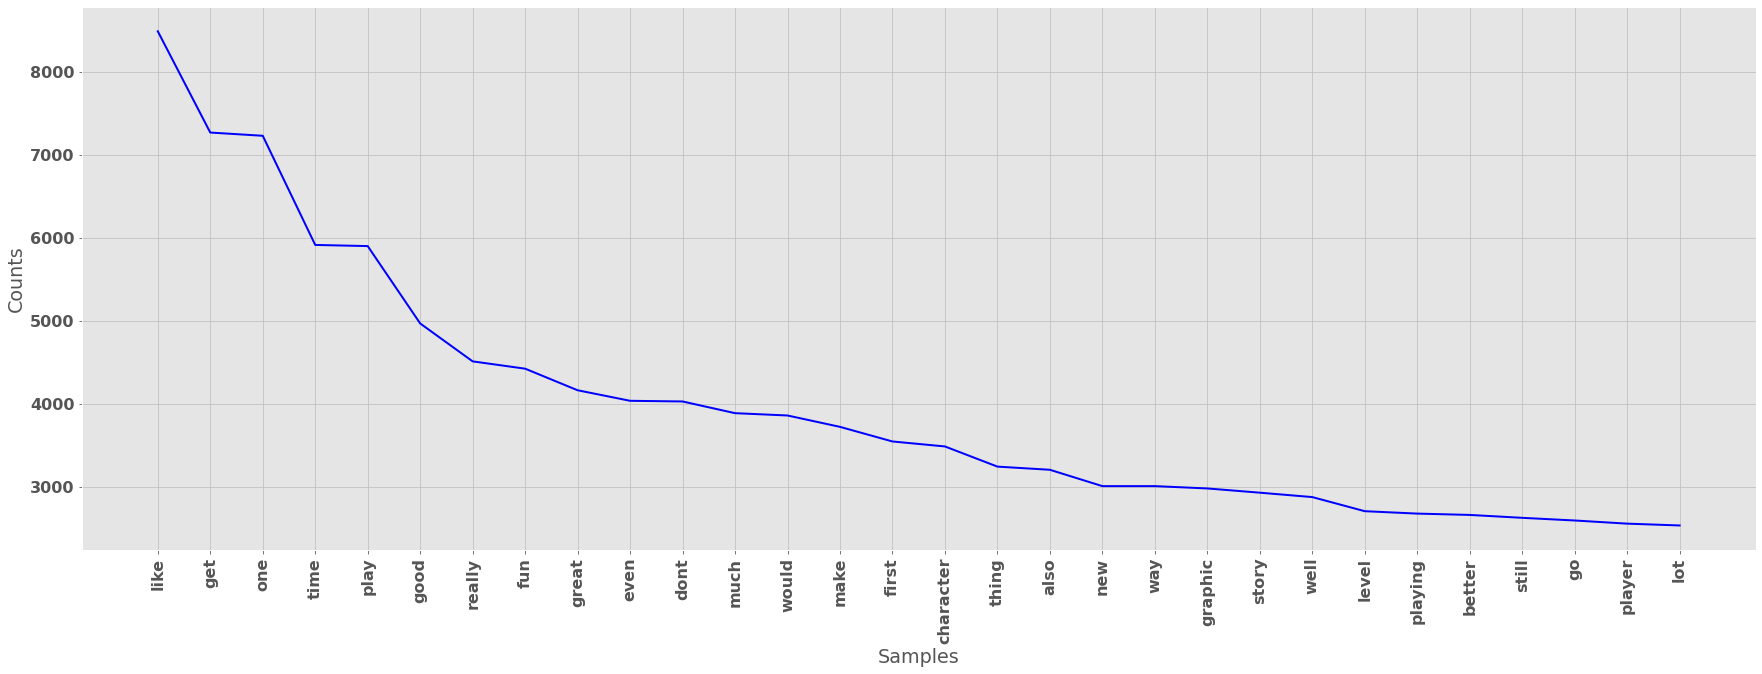

In [99]:
text = ' '.join(list(dfReview['reviewText_prep']))
freq = FreqDist(text.split())
plt.figure(figsize=(30,10))
p = freq.plot(30,color='blue')

<font size="3">Esse "like" pode ser no sentido **i like it** ou associativo **its like a something** ...</font>

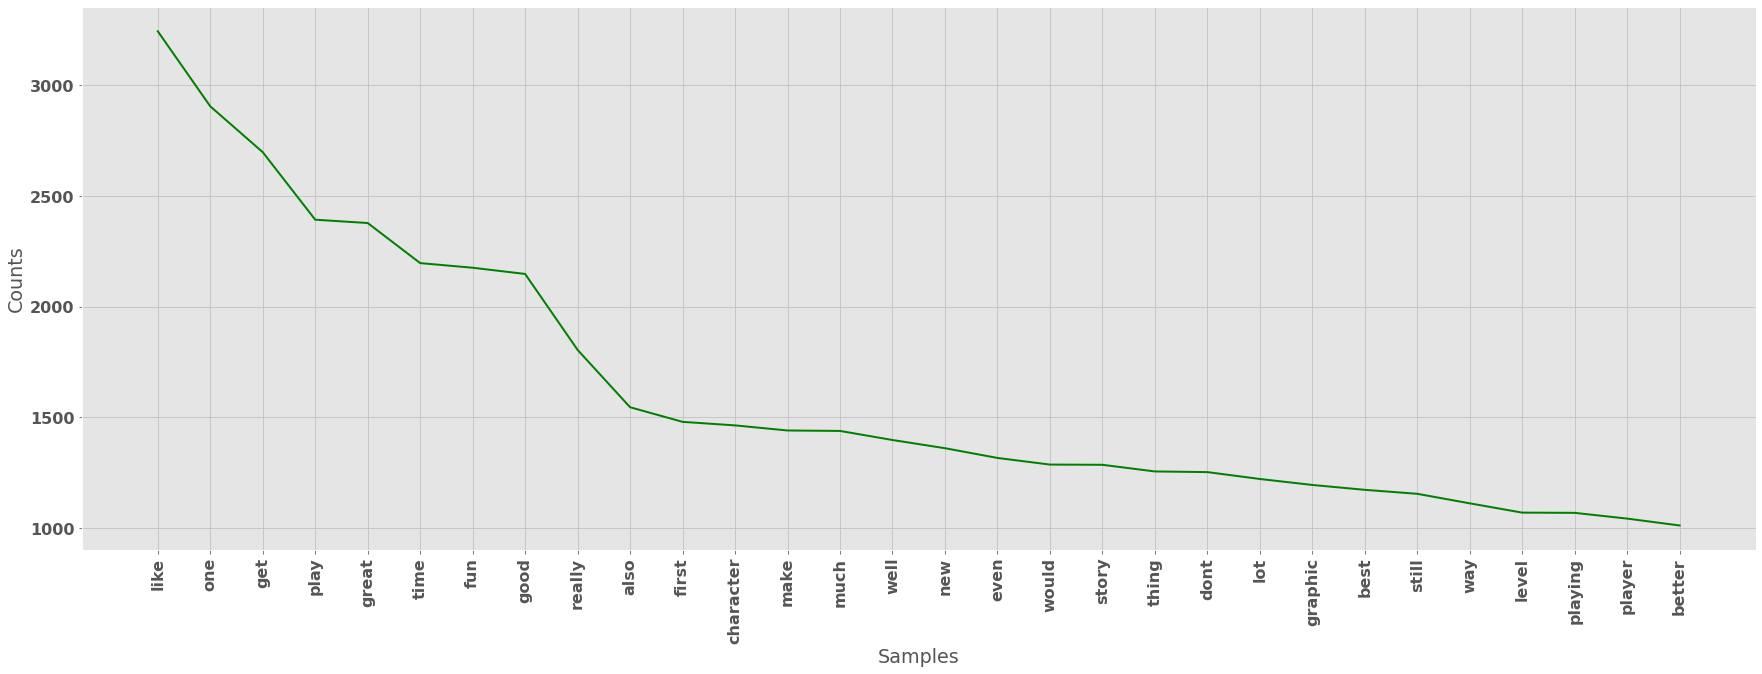

In [100]:
text = ' '.join(list(dfReview[dfReview['overallBinary'] == 1]['reviewText_prep']))
freq = FreqDist(text.split())
plt.figure(figsize=(30,10))
p = freq.plot(30, color='green')

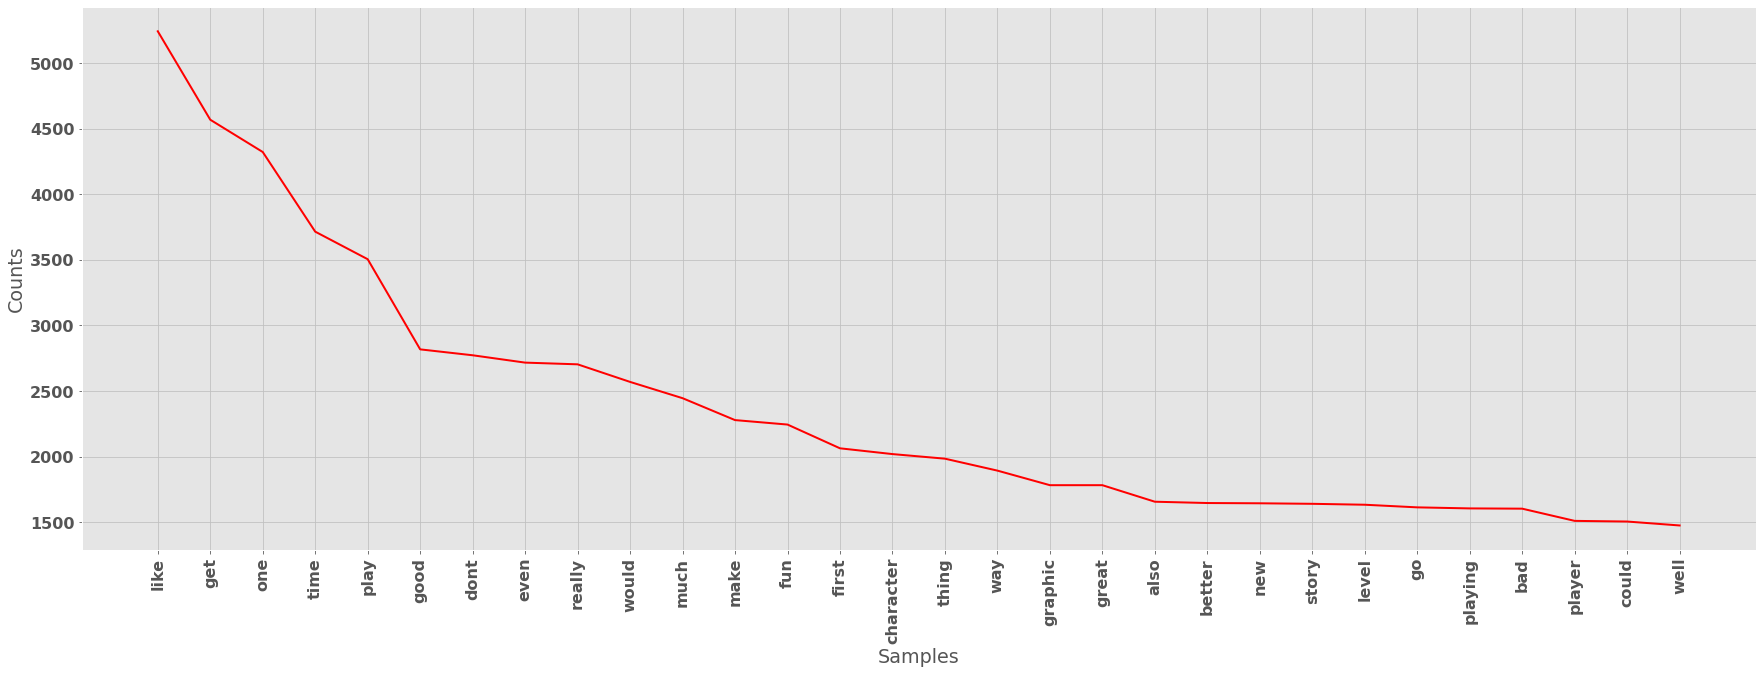

In [101]:
text = ' '.join(list(dfReview[dfReview['overallBinary'] == 0]['reviewText_prep']))
freq = FreqDist(text.split())
plt.figure(figsize=(30,10))
p = freq.plot(30, color='red')

In [ ]:
ret, mask = cv.threshold(cv.imread('imagens/controller.png'),
                         55,
                         255,
                         cv.THRESH_BINARY)

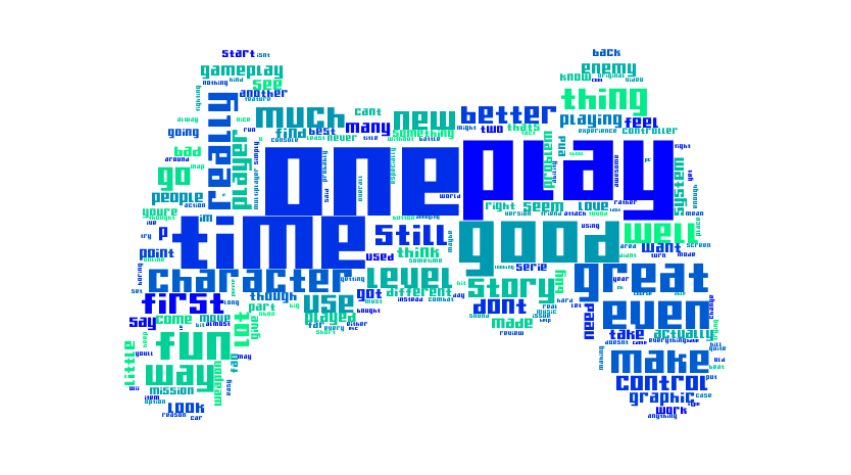

In [82]:
text = ' '.join(list(dfReview['reviewText_prep']))

wordcloud = WordCloud(background_color="white",
                      width=500, height=500,
                      mask=mask, 
                      font_path='Gamer.ttf',
                      colormap="winter",).generate(text)

plt.figure(figsize=(15,10))
p = plt.imshow(wordcloud, interpolation='bilinear')
p = plt.axis("off")

In [88]:
ret, maskP = cv.threshold(cv.imread('imagens/pos.png'),
                         55,
                         255,
                         cv.THRESH_BINARY)

ret, maskN = cv.threshold(cv.imread('imagens/neg.png'),
                         55,
                         255,
                         cv.THRESH_BINARY)

(-0.5, 224.5, 224.5, -0.5)

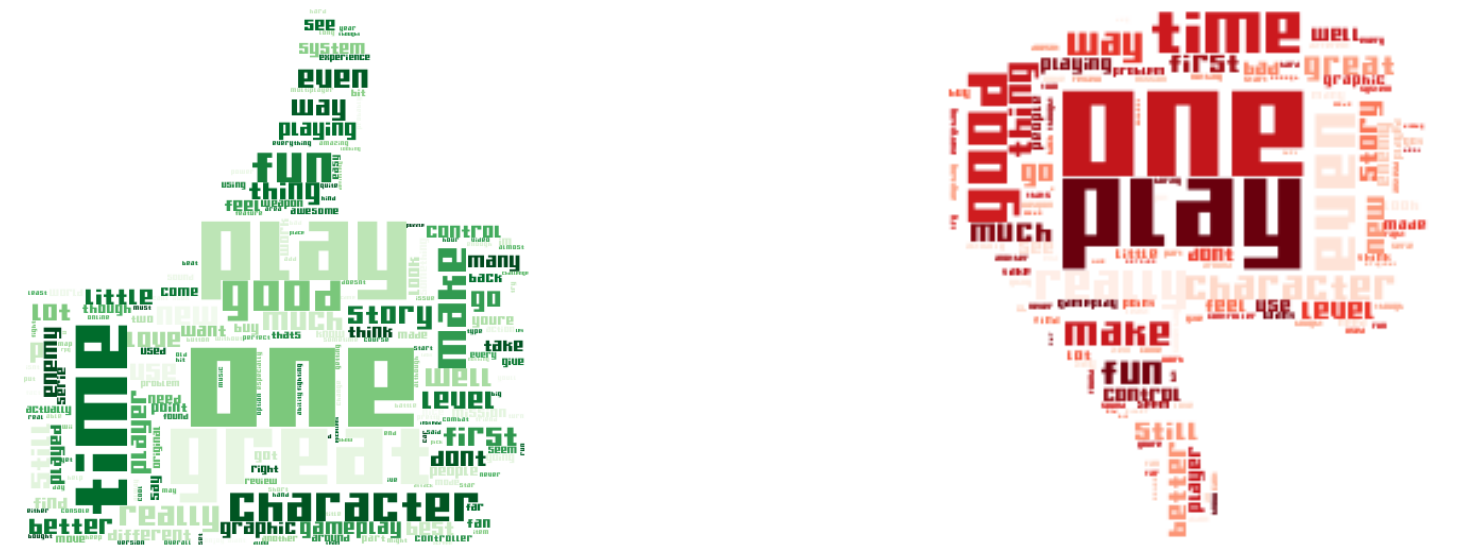

In [97]:
text = ' '.join(list(dfReview[dfReview['overallBinary'] == 1]['reviewText_prep']))

wordcloudP = WordCloud(background_color="white",
                      width=500, height=500,
                      mask=maskP, 
                      font_path='Gamer.ttf',
                      colormap="Greens",).generate(text)

text = ' '.join(list(dfReview[dfReview['overallBinary'] == 0]['reviewText_prep']))

wordcloudN = WordCloud(background_color="white",
                      width=500, height=500,
                      mask=maskN, 
                      font_path='Gamer.ttf',
                      colormap="Reds",).generate(text)

fig, ax = plt.subplots(1, 2, figsize=(30,10))
ax[0].imshow(wordcloudP, interpolation='bilinear')
ax[1].imshow(wordcloudN, interpolation='bilinear')

ax[0].axis("off")
ax[1].axis("off")

In [111]:
texto = nltk.Text(' '.join(list(dfReview['reviewText_prep'])).split())

In [112]:
texto.concordance('like')

Displaying 25 of 8485 matches:
stroying error jammin banging really like love challenge love different place 
 charge paid im bethesdas payroll id like able play instead feeling like got r
ll id like able play instead feeling like got robbed lied update patch issued 
 bad story beginning though wow look like really cool timeline splitting story
pon premise completely awesome least like time travel stuff however narrative 
ke much expensive mistake still sort like would willing bet one come price rat
on even enjoy slower paced sometimes like deblob near captivating buy donkey k
lob near captivating buy donkey kong like jump around squash thing much better
little distractionwith onto badwhile like croft manor inability replay level r
level begin show terrible werei felt like nothing assault course lara go littl
insult injury level far short coming like exploring every nook cranny every le
re first conquer puzzle get main bos like anniversarylara look great wear fall
t injury showing clea

In [113]:
texto.concordance('one')

Displaying 25 of 7226 matches:
wasted dollar xbox one ive got play console honestly say loo
nestly say look x better p maybe xbox one messed p killed margots word brain gi
mechanic mildly interesting character one two good weapon premise completely aw
 story unfoldswell worth picking rent one couldnt keep year old attention minut
ake still sort like would willing bet one come price rather quickly wait compar
h thing much better wont disappointed one returned christmas gift poor nothing 
 high price sold store wait youll get one probably cheaper store price second h
amount damage didnt react fast enough one easy challenge thus funthe level obvi
n put puzzle disappointed werent many one level begin show terrible werei felt 
un yet challenging unlike many sequel one improved thing really hasnt changed g
 fun several mini within main gamethe one thing dont like cant move forward ont
 allow aim much precisionxiii lengthy one player mode level connected good stor
econ jungle storm support pl

In [114]:
texto.concordance('play')

Displaying 25 of 5897 matches:
wasted dollar xbox one ive got play console honestly say look x better p
id im bethesdas payroll id like able play instead feeling like got robbed lied
second time row hoop ask player jump play mess balance basketball nose playing
playing altered themits ok simulator play somewhat competent opponent style to
stion whether gta iv two episode fun play answer yes even though clear rocksta
 priced set big deal important thing play series order released gta iv tlad tb
play level removed forcing start new play againthe bonoculars although cool us
rtaining get thru cod desire go back play yet playing different name slight ch
tent goody preview k cut many option play online like disastrous match making 
wever gameplay work properly lot fun play different character movie dormouse w
eat value used bought used son could play friend baseball postseason really li
ed really liked used price important play first first begin point think story 
apon sound wimpy hard contr

In [115]:
texto.concordance('time')

Displaying 25 of 5911 matches:
gaming experience point gamers spend time forum looking help support using enj
eyif buy new car dont sit still bide time either cardealer keep promising migh
roll v skyrim could great maybe year time forumgeeks helped gamecompany fix fr
nplayableunfinishable certain amount time part patch seems remedy problem prev
running little smoother short period time nice going bethesda considering skip
 sit press select button adjust wait time press x wait second time row hoop as
adjust wait time press x wait second time row hoop ask player jump play mess b
remise completely awesome least like time travel stuff however narrative error
 crash scene rockstars rashomon long time fan grand theft auto know postps era
ear rockstar devoted lot development time luis episode johnny episode tlad fee
similar gta iii many way youll spend time following main story driving riding 
side activity minigames player spend time tbogt tladbut theyre part value pric
t make past minute ga

In [116]:
texto.similar('like')

good get fun play really great one better know think buy want make
much even work bad dont say new


In [117]:
texto.similar('play')

get like one playing really fun good go thing dont work make feel look
great time buy first think see


In [118]:
texto.similar('one')

time first play get good thing like many really much two fun level
great graphic dont lot way even p


## Modelagem

In [350]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score

def mostra_metricas(y_true, y_pred):
  ''' Função que recebe o y real, o y predito e mostra as
      principais metricas.
  '''
  print("Acurácia: ", accuracy_score(y_true, y_pred))
  print("\nAUROC:", roc_auc_score(y_true, y_pred))
  print("\nF1-Score:", f1_score(y_true, y_pred, average='weighted'))
  print("\nMatriz de confusão:")
  sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
  plt.show()

### TF-IDF

In [372]:
tfidf_vect = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vect.fit_transform(dfReview['reviewText_prep'])

In [373]:
print(X_tfidf)

(0, 2362)     0.28510978103416845
  (0, 2710)     0.39014830600773676
  (0, 2665)     0.22375693851448133
  (0, 406)      0.15161913601846758
  (0, 2547)     0.16500577764486943
  (0, 3782)     0.16854459016161133
  (0, 2080)     0.28197278612779514
  (0, 867)      0.2308324290210661
  (0, 3210)     0.1176932074786112
  (0, 1881)     0.17253345715089757
  (0, 2310)     0.1856962955951335
  (0, 2990)     0.22675731049451012
  (0, 4957)     0.42673668334525566
  (0, 1229)     0.29125923259380826
  (0, 4825)     0.32948007487109954
  (1, 1753)     0.10889666072443233
  (1, 3215)     0.12648245018966606
  (1, 786)      0.15108221643471081
  (1, 460)      0.3218600711019063
  (1, 2755)     0.23794365370676562
  (1, 3970)     0.19320255713795778
  (1, 2960)     0.3046381309500056
  (1, 1617)     0.210456999720373
  (1, 813)      0.30820472530881105
  (1, 590)      0.14567537333806485
  :     :
  (7999, 4854)  0.05458097648689486
  (7999, 1859)  0.05672429945850727
  (7999, 2561)  0.058262246824933576
  (7999, 2087)  0.1756615006968512
  (7999, 665)   0.05958799672374421
  (7999, 4450)  0.0537620020845075
  (7999, 2367)  0.11152059114161057
  (7999, 3929)  0.15313178028710508
  (7999, 2302)  0.3398825088871534
  (7999, 2622)  0.12045700724954733
  (7999, 1281)  0.09985131797213392
  (7999, 4180)  0.07131608660112902
  (7999, 2348)  0.07304000983610084
  (7999, 4494)  0.04449468516297852
  (7999, 3038)  0.07822154563756212
  (7999, 1899)  0.05183131234923323
  (7999, 2518)  0.06082567560631498
  (7999, 1786)  0.06352682433817139
  (7999, 1628)  0.052624650739938376
  (7999, 1831)  0.12328096528238087
  (7999, 1164)  0.06614128219094213
  (7999, 3659)  0.0682858059803821
  (7999, 1753)  0.09453444233822542
  (7999, 1617)  0.09135006974680232
  (7999, 2990)  0.041404946485086434

### Modelos

In [374]:
dfReviewTest = pd.read_csv('video_games_reviews_test.csv')
dfReviewValid = pd.read_csv('video_games_reviews_dev.csv')

In [375]:
X_train = X_tfidf
y_train = dfReview['overallBinary']

X_test = tfidf_vect.transform(dfReviewTest['reviewText'].replace(np.nan, ''))
y_test = dfReviewTest['overall'].apply(lambda x:1 if x > 3 else 0)

#### Random Forest

In [400]:
rf = RandomForestClassifier(200)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [401]:
y_dt_pred = rf.predict(X_test)
#mostra_metricas(y_test, y_dt_pred)

Acurácia:  0.774

AUROC: 0.7423058179637128

F1-Score: 0.7665601808357932

Matriz de confusão:

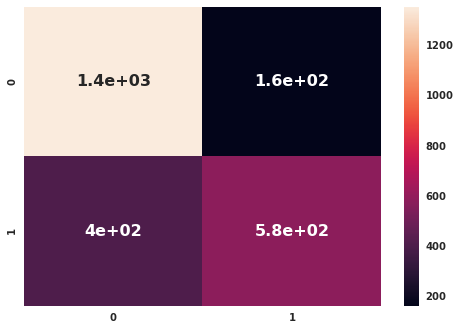

In [402]:
mostra_metricas(y_test, y_dt_pred)

##### Validacao

In [404]:
X_valid = tfidf_vect.transform(dfReviewValid['reviewText'].replace(np.nan, ''))
y_valid = dfReviewValid['overall'].apply(lambda x:1 if x > 3 else 0)
allScores = cross_val_score(rf, X_valid, y_valid , cv=10)

In [406]:
allScores.mean()

0.714

In [383]:
def testes(texto):
    yvect = tfidf_vect.transform([texto])
    ypred = rf.predict(yvect)
    if ypred == 0:
        print("Essa é uma review negativa.")
    else:
        print("Essa é uma review positiva.")

In [386]:
testes('good')

Essa é uma review positiva.

#### Regressao Logistica

In [389]:
reglog2 = LogisticRegression()
reglog2.fit(X_train, y_train)

y2_reglog_pred = reglog2.predict(X_test)

Acurácia:  0.784

AUROC: 0.764077662103978

F1-Score: 0.7813112732664768

Matriz de confusão:

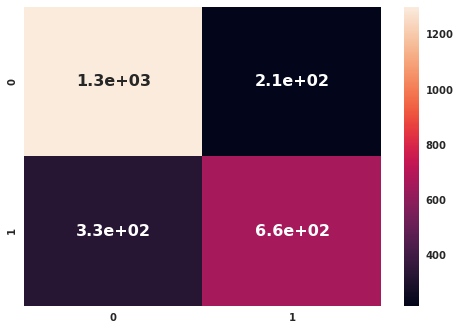

In [390]:
y2_reglog_pred = reglog2.predict(X_test)
mostra_metricas(y_test, y2_reglog_pred)

# criar uma lista de reviwes para testar os modelos e criar um barplot copm hue nos modelos